# <center><font color=#76B900 size="+3"><b>**CVRPTW Exercise**</b></font></center>
---

**Learning Objectives:**
- Test your ability to model a routing optimization problem with cuOpt

### Exercise
You have the following information and constraints:
- 9 Locations:
    - 1 Depot (e.g. Office or Warehouse)
    - 8 (Clients/Customer)
- Number of vehicles 6
- Each vehicle has an associated capacities
- Each location has a specific time window within which services/deliveries need to be performed
- Demand may differ across locations
- Each vehicle has a time window of its availability
- Each vehicle has an associated priority

problem details are provided below, use NVIDIA cuOpt to determine an optimized route plan

In [1]:
coordinates      = [ [3, 2],   [4, 8], [7, 2], [1, 3], [8, 9], [5, 1], [2, 5], [4, 2], [0, 1]]
locations        = [ "Depot",   "A",    "B",    "C",    "D",    "E",    "F",    "G",   "H"   ]
# Number of orders to be delivered at each location, this can be number of orders, weight or volumne
orders           = [   0,        3,      4,      4,      3,      4,      3,      2,     5    ]
# Earliest a delivery can be made
l_tw_earliest    = [   0,        3,      5,      3,      1,      8,      4,      0,     10   ]
# Latest a delivery can be made
l_tw_latest      = [1000,       20,     30,     15,     20,     12,     40,     30,     20   ]
# Service time required for the delivery
l_tw_service     = [   0,         1,     1,      1,       1,     2,      3,      1,     2    ]
n_locations      = len(locations)
n_vehicles       = 6
# Number of orders each vehicle can carry, this can be number of orders, weight or volumne
vehicle_capacity = [3,   8,  7,  9,  5,  10]
# Earliest a vehicle can start 
v_tw_earliest    = [0,   1,  3,  5,  20, 30]
# Latest a vehicle will be working
v_tw_latest      = [80, 40, 30, 80, 100, 40]
# Vehicle Priority, lower value higher priority
v_priorities     = [0,   3,  2,  1,  2, 100]
min_vehicles     = 4
n_climbers       = 64
time_limit       = 0.1

colors      = ["blue", "white", "green", "pink", "yellow", "orange"]


**Hints and answers have been provided below under each section.**

## Import Libraries

In [2]:
from cuopt import routing
import cudf
import pandas as pd
from scipy.spatial import distance
import helper_function.helper_map as helper_map

## Create DataFrame

Create a Pandas dataframe from given coordinates, this would be used to generate distance/cost matrix

In [3]:
# df = # Add your code here
df = pd.DataFrame(coordinates, columns=['xcord', 'ycord'], index=locations)
df

,xcord,ycord
Depot,3,2
A,4,8
B,7,2
C,1,3
D,8,9
E,5,1
F,2,5
G,4,2
H,0,1


<details><summary>Answer</summary>
<p>
df = pd.DataFrame(coordinates, columns=['xcord', 'ycord'], index=locations)
</p></details>

### Visualize Depot and Destinations

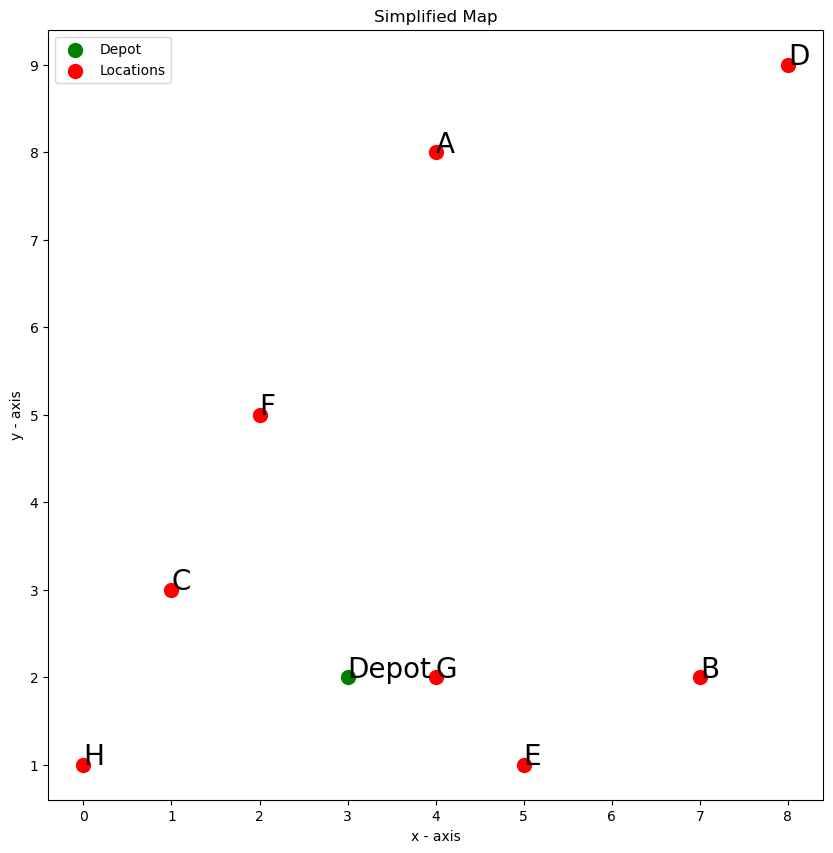

In [4]:
# Not a mandatory, you can skip this
helper_map.gen_plot(df).show()

## Create Distance/Cost Matrix

Create a cuDF dataframe from the distance matrix

In [5]:
#distance_matrix = # Add your code here to create distance matrix
distance_matrix = distance.cdist(df.values, df.values, "euclidean")

#distance_matrix = # Add your code create cuDF Dataframe
distance_matrix = cudf.DataFrame(distance_matrix, index=df.index, columns=df.index)

distance_matrix

,Depot,A,B,C,D,E,F,G,H
Depot,0.000000,6.082763,4.000000,2.236068,8.602325,2.236068,3.162278,1.000000,3.162278
A,6.082763,0.000000,6.708204,5.830952,4.123106,7.071068,3.605551,6.000000,8.062258
B,4.000000,6.708204,0.000000,6.082763,7.071068,2.236068,5.830952,3.000000,7.071068
C,2.236068,5.830952,6.082763,0.000000,9.219544,4.472136,2.236068,3.162278,2.236068
D,8.602325,4.123106,7.071068,9.219544,0.000000,8.544004,7.211103,8.062258,11.313708
E,2.236068,7.071068,2.236068,4.472136,8.544004,0.000000,5.000000,1.414214,5.000000
F,3.162278,3.605551,5.830952,2.236068,7.211103,5.000000,0.000000,3.605551,4.472136
G,1.000000,6.000000,3.000000,3.162278,8.062258,1.414214,3.605551,0.000000,4.123106
H,3.162278,8.062258,7.071068,2.236068,11.313708,5.000000,4.472136,4.123106,0.000000


<details><summary>Answer</summary>
<p>
distance_matrix = distance.cdist(df.values, df.values, "euclidean")
    
distance_matrix = cudf.DataFrame(distance_matrix, index=df.index, columns=df.index)
</p></details>

## Create Data-Model

**Hint**: What are you planning to do with vehicle priority ? Use `set_vehicle_priority`

In [6]:
# data_model =

data_model = routing.DataModel( n_locations, n_vehicles )

data_model.add_cost_matrix( distance_matrix )

data_model.add_capacity_dimension( "demand", cudf.Series(orders), cudf.Series(vehicle_capacity) )

data_model.set_order_time_windows( cudf.Series(l_tw_earliest), cudf.Series(l_tw_latest) )

data_model.set_order_service_times(cudf.Series(l_tw_service) )

data_model.set_vehicle_time_windows( cudf.Series(v_tw_earliest), cudf.Series(v_tw_latest) )

data_model.set_min_vehicles(min_vehicles)

# Priority for vehicles
data_model.set_vehicle_priorities(cudf.Series(v_priorities))

<details><summary>Answer</summary>
<p>
data_model = routing.DataModel(
    n_locations, n_vehicles
)

data_model.add_cost_matrix(
    distance_matrix
)

data_model.add_capacity_dimension(
    "demand", cudf.Series(orders), cudf.Series(vehicle_capacity)
)

data_model.set_order_time_windows(
    cudf.Series(l_tw_earliest), cudf.Series(l_tw_latest)
)

data_model.set_order_service_times(cudf.Series(l_tw_service)
)

data_model.set_vehicle_time_windows(
    cudf.Series(v_tw_earliest), cudf.Series(v_tw_latest)
)
    
data_model.set_min_vehicles(min_vehicles)
    
#### Priority for vehicles
data_model.set_vehicle_priorities(cudf.Series(v_priorities))
</p></details>

## Create Solver Instance

In [7]:
#solver =
solver_settings = routing.SolverSettings()
solver_settings.set_number_of_climbers(n_climbers)
solver_settings.set_time_limit(time_limit)

#routing_solution = 
routing_solution = routing.Solve(data_model, solver_settings)

<details><summary>Answer</summary>
<p>
solver_settings = routing.SolverSettings()

solver_settings.set_number_of_climbers(n_climbers)

solver_settings.set_time_limit(time_limit)

routing_solution = routing.Solve(data_model, solver_settings)
</p></details>

## CVRPTW Results

In [8]:
if routing_solution.get_status() == 0:
    print("Cost for the routing in distance: ", routing_solution.final_cost)
    print("Vehicle count to complete routing: ", routing_solution.vehicle_count)
    helper_map.show_vehicle_routes(routing_solution.route, locations)
    routing_solution.route
else:
    print("NVIDIA cuOpt Failed to find a solution with status : ", routing_solution.get_status())

Cost for the routing in distance:  42.68257141113281
Vehicle count to complete routing:  4
For vehicle - 1 route is: 

Depot->B->E->Depot


For vehicle - 2 route is: 

Depot->D->A->Depot


For vehicle - 3 route is: 

Depot->C->H->Depot


For vehicle - 4 route is: 

Depot->G->F->Depot




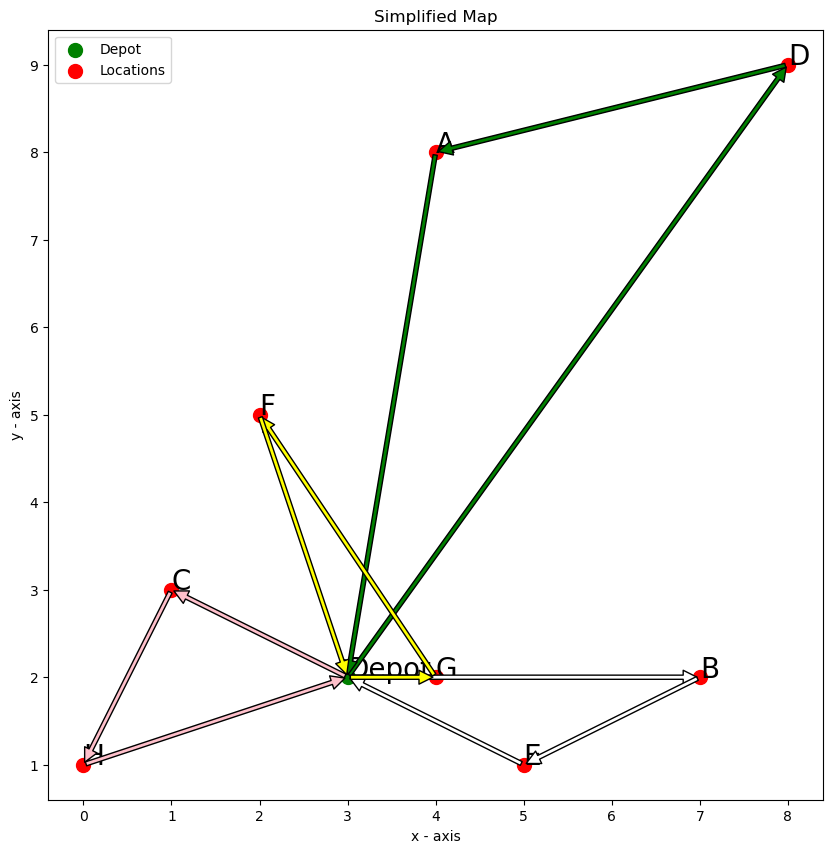

In [9]:
helper_map.map_vehicle_routes(df, routing_solution.route, colors).show()

If you can see a `Map` and see a `Final Cost` reported, this means NVIDIA cuOpt was able to find an optimized route sequence. 

From here you can modify the input data to determine its impact on result and explore other supported APIs.

In [10]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}


## What's Next?

Real-world problems can potentially contain 1000s of locations and 100s of vehicles. NVIDIA cuOpt can scale to deliver unique value for problems of this size.

#### Next is an optional notebook showcasing a large CVRPTW benchmark problem. [please click to continue](./05_cvrptw_homberger_cuopt.ipynb). 

<center><a href="https://www.nvidia.com/dli"> <img src="images/DLI_Header.png" alt="Header" style="width: 400px;"/> </a></center>